# Interpret a Keras Model that Predicts College Debt with SHAP

To run the notebook directly in your browser, use Colab [here](https://colab.research.google.com/github/kweinmeister/notebooks/blob/master/tensorflow-shap-college-debt.ipynb).

## Imports

In [ ]:
!pip install tensorflow
!pip install shap
!pip install seaborn

In [2]:
%matplotlib inline 

import pandas as pd
import numpy as np
import math

import seaborn as sns
import matplotlib.pyplot as plt

import shap
shap.initjs()

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

1.12.0


## Download Data

In [3]:
# Consider downloading the dataset and using a local reference
CSV_FILE = 'https://ed-public-download.app.cloud.gov/downloads/Most-Recent-Cohorts-All-Data-Elements.csv'
df_raw = pd.read_csv(CSV_FILE, low_memory=False)
df_raw.head()

,UNITID,OPEID,OPEID6,INSTNM,CITY,STABBR,ZIP,ACCREDAGENCY,INSTURL,NPCURL,...,OMAWDP6_FTNFT_POOLED_SUPP,OMAWDP8_FTNFT_POOLED_SUPP,OMENRYP8_FTNFT_POOLED_SUPP,OMENRAP8_FTNFT_POOLED_SUPP,OMENRUP8_FTNFT_POOLED_SUPP,OMAWDP6_PTNFT_POOLED_SUPP,OMAWDP8_PTNFT_POOLED_SUPP,OMENRYP8_PTNFT_POOLED_SUPP,OMENRAP8_PTNFT_POOLED_SUPP,OMENRUP8_PTNFT_POOLED_SUPP
0,100654,100200,1002,Alabama A & M University,Normal,AL,35762,Southern Association of Colleges and Schools C...,www.aamu.edu/,www2.aamu.edu/scripts/netpricecalc/npcalc.htm,...,0.4694,0.5136,0.0034,0.1429,0.3401,0.3333,0.3333,0,0,0.6667
1,100663,105200,1052,University of Alabama at Birmingham,Birmingham,AL,35294-0110,Southern Association of Colleges and Schools C...,www.uab.edu,uab.studentaidcalculator.com/survey.aspx,...,0.6117,0.624,0.0075,0.2166,0.1519,0.3642,0.4,0.0434,0.2755,0.2811
2,100690,2503400,25034,Amridge University,Montgomery,AL,36117-3553,Southern Association of Colleges and Schools C...,www.amridgeuniversity.edu,www2.amridgeuniversity.edu:9091/,...,0.5503,0.5562,0.0059,0.4379,0,0.4429,0.4714,0.0429,0.4857,0
3,100706,105500,1055,University of Alabama in Huntsville,Huntsville,AL,35899,Southern Association of Colleges and Schools C...,www.uah.edu,finaid.uah.edu/,...,0.5456,0.5651,0.0123,0.2841,0.1385,0.3378,0.3547,0.0236,0.4257,0.1959
4,100724,100500,1005,Alabama State University,Montgomery,AL,36104-0271,Southern Association of Colleges and Schools C...,www.alasu.edu,www.alasu.edu/cost-aid/forms/calculator/index....,...,0.4105,0.429,0.0062,0.216,0.3488,0.2931,0.3103,0.0345,0.3966,0.2586


## Preprocess data

### Helper functions

In [4]:
# Calculate the ratio between student loan debt and future earnings
# Any missing or invalid values will return NaN
def debt_earnings_ratio(row):
    try:
        d = float(row['MD_INC_DEBT_MDN'])
    except:
        return np.nan
    
    try:
        e = float(row['MN_EARN_WNE_INC2_P6'])
    except:
        return np.nan

    return d / e

# Net price in raw data is provided in separate columns.
# This function returns the value found in either public and private institutions.
# It also returns an average across two family household income levels.

def net_price(row):

    # First, check public institutions in the 30-48k and 48k-75k columns
    if not math.isnan(row['NPT42_PUB']) and not math.isnan(row['NPT43_PUB']):

        # Return mean of both middle income levels
        return (row['NPT42_PUB'] + row['NPT43_PUB']) / 2
    
    # Repeat for private institutions
    if not math.isnan(row['NPT42_PRIV']) and not math.isnan(row['NPT43_PRIV']):
        return (row['NPT42_PRIV'] + row['NPT43_PRIV']) / 2
    
    return np.nan

### Define features

In [5]:
# Make a copy of the dataframe to start over from this cell as needed, without downloading CSV again
df = df_raw.copy()

FEATURES = ['ADM_RATE', 'SAT_AVG', 'TRANS_4', 'NPT4','INC_N', 'PUBLIC', 'UGDS','PPTUG_EF','FIRST_GEN','MD_INC_COMP_ORIG_YR4_RT']
LABEL = 'MD_INC_DEBT_EARNINGS_RATIO'
SELECTED_COLUMNS = FEATURES + [LABEL]

# Create new feature derived from debt and future earnings data 
df['MD_INC_DEBT_EARNINGS_RATIO'] = df.apply(lambda row: debt_earnings_ratio(row), axis=1)

# One-hot encode if the institution is public or not
control = df.pop('CONTROL')
df['PUBLIC'] = (control == 1)*1.0

# Create a new feature for the net price of the university, combining this data from multiple columns
df['NPT4'] = df.apply(lambda row: net_price(row),axis=1)


### Trim columns

In [6]:
# Remove all columns except for features and label columns
df = df[SELECTED_COLUMNS]
print(df.shape)

# Remove rows that have missing labels due to fewer than 30 students polled
PRIVACY_SUPPRESSED = 'PrivacySuppressed'
df = df[df!=(PRIVACY_SUPPRESSED)]
print(df.shape)

# Drop rows with missing data
df = df.dropna()
print(df.shape)

# Convert types to numeric
df[SELECTED_COLUMNS] = df[SELECTED_COLUMNS].apply(pd.to_numeric)
                              
df.head()

(7175, 11)
(7175, 11)
(1117, 11)


/Users/kweinmeister/Projects/jupyterlab/lib/python3.6/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


,ADM_RATE,SAT_AVG,TRANS_4,NPT4,INC_N,PUBLIC,UGDS,PPTUG_EF,FIRST_GEN,MD_INC_COMP_ORIG_YR4_RT,MD_INC_DEBT_EARNINGS_RATIO
0,0.8738,849.0,0.3765,16413.0,3186,1.0,4616.0,0.0877,0.365828,0.239382,0.437096
1,0.5814,1125.0,0.2433,16703.5,5367,1.0,12047.0,0.2578,0.341224,0.472991,0.369543
3,0.7628,1257.0,0.2983,19158.0,2389,1.0,6346.0,0.1746,0.310132,0.447531,0.338982
4,0.4590,825.0,0.0000,16316.0,2504,1.0,4704.0,0.0727,0.343434,0.231552,0.632638
5,0.5259,1202.0,0.2104,21219.0,9310,1.0,31663.0,0.0819,0.225713,0.476113,0.422101


## Visualize data

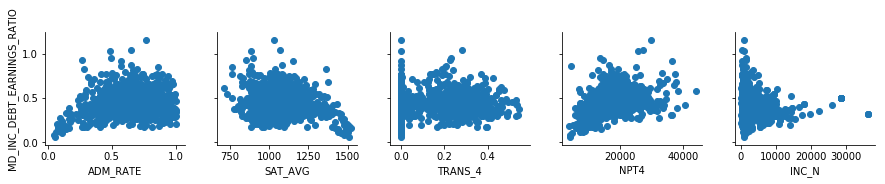

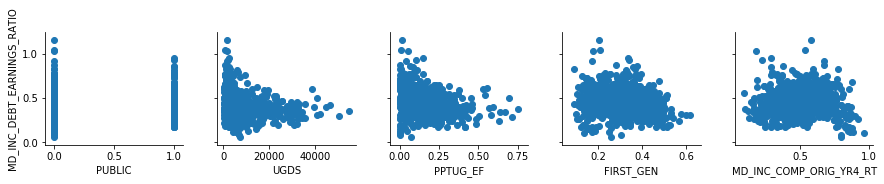

In [7]:
g = sns.PairGrid(df, x_vars=FEATURES[0:5], y_vars=LABEL)
g.map(plt.scatter);
g = sns.PairGrid(df, x_vars=FEATURES[5:10], y_vars=LABEL)
g.map(plt.scatter);

## Describe data

In [8]:
# Extract labels
df_train = df
train_labels = df_train.pop(LABEL)

# Describe the dataset
train_stats = df_train.describe()
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
ADM_RATE,1117.0,0.664153,0.181681,0.048100,0.555500,0.682500,0.790800,1.000000
SAT_AVG,1117.0,1058.559534,124.330852,712.000000,975.000000,1040.000000,1115.000000,1519.000000
TRANS_4,1117.0,0.123557,0.148810,0.000000,0.000000,0.004000,0.255700,0.542900
NPT4,1117.0,17331.498209,5870.112300,3600.500000,13189.500000,16879.500000,20680.500000,44120.500000
INC_N,1117.0,3334.373321,5074.552429,155.000000,773.000000,1413.000000,3817.000000,36424.000000
PUBLIC,1117.0,0.434199,0.495873,0.000000,0.000000,0.000000,1.000000,1.000000
UGDS,1117.0,6272.341987,7904.776039,181.000000,1452.000000,2943.000000,7447.000000,55113.000000
PPTUG_EF,1117.0,0.123639,0.110857,0.000000,0.042200,0.094200,0.170900,0.755800
FIRST_GEN,1117.0,0.315067,0.092428,0.088670,0.251003,0.320899,0.377976,0.615339
MD_INC_COMP_ORIG_YR4_RT,1117.0,0.495971,0.144794,0.088608,0.400000,0.489796,0.587500,0.963746


## Normalize data

In [9]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

df_train_normed = norm(df_train)

df_train_normed.head()

,ADM_RATE,SAT_AVG,TRANS_4,NPT4,INC_N,PUBLIC,UGDS,PPTUG_EF,FIRST_GEN,MD_INC_COMP_ORIG_YR4_RT
0,1.153925,-1.685499,1.699775,-0.156470,-0.029239,1.14102,-0.209537,-0.324192,0.549199,-1.772098
1,-0.455487,0.534384,0.804673,-0.106982,0.400553,1.14102,0.730528,1.210217,0.282999,-0.158710
3,0.542965,1.596068,1.174272,0.311153,-0.186297,1.14102,0.009318,0.459701,-0.053387,-0.334545
4,-1.129194,-1.878532,-0.830301,-0.172995,-0.163635,1.14102,-0.198404,-0.459501,0.306916,-1.826176
5,-0.760967,1.153700,0.583585,0.662253,1.177567,1.14102,3.212065,-0.376511,-0.966737,-0.137144


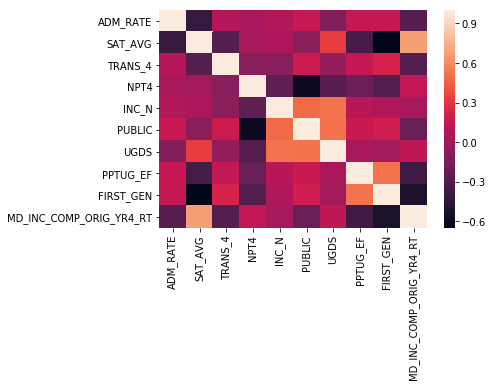

In [10]:
corr = df.corr()
sns.heatmap(corr)

## Build model

In [11]:
def build_model(df):
  model = keras.Sequential([
    layers.Dense(16, activation=tf.nn.relu, input_shape=[len(df.keys())]),
    layers.Dense(16, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  # TF 2.0: optimizer = tf.keras.optimizers.RMSprop()
  optimizer = tf.keras.optimizers.RMSprop()
  # optimizer = tf.train.RMSPropOptimizer(learning_rate=0.001)
    
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae'])
  return model

model = build_model(df_train_normed)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                176       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 465
Trainable params: 465
Non-trainable params: 0
_________________________________________________________________


## Train model

In [12]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 1000

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

history = model.fit(
  df_train_normed, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[early_stop, PrintDot()])


.................................................................................

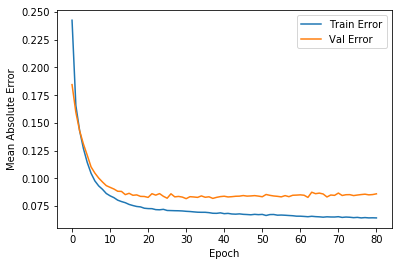

In [13]:
import matplotlib.pyplot as plt

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

def plot_history(history):
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Absolute Error')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.legend()
  
plot_history(history)

## Explain model

### KernelExplainer

In [14]:
# KernelExplainer is a general approach that can work with any ML framework
# Its inputs are the predictions and training data

# Summarize the training set to accelerate analysis
df_train_normed_summary = shap.kmeans(df_train_normed.values, 25)

# Instantiate an explainer with the model predictions and training data summary
explainer = shap.KernelExplainer(model.predict, df_train_normed_summary)

# Extract Shapley values from the explainer
shap_values = explainer.shap_values(df_train_normed.values)

  0%|          | 0/1117 [00:00<?, ?it/s]/Users/kweinmeister/Projects/jupyterlab/lib/python3.6/site-packages/shap/explainers/kernel.py:535: UserWarning: l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
  "l1_reg=\"auto\" is deprecated and in the next version (v0.29) the behavior will change from a " \
100%|██████████| 1117/1117 [04:18<00:00,  4.43it/s]


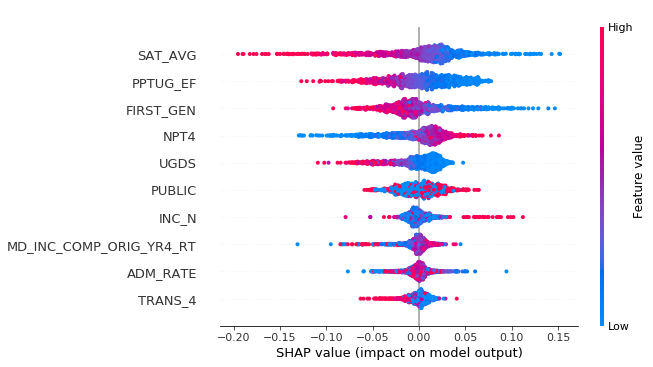

In [15]:
# Summarize the Shapley values in a plot
shap.summary_plot(shap_values[0], df_train)

In [16]:
# Plot the SHAP values for one instance
INSTANCE_NUM = 0
shap.force_plot(explainer.expected_value[0], shap_values[0][INSTANCE_NUM], df_train.iloc[INSTANCE_NUM,:])

In [17]:
# Plot the SHAP values for multiple instances
NUM_ROWS = 10
shap.force_plot(explainer.expected_value[0], shap_values[0][0:NUM_ROWS], df_train.iloc[0:NUM_ROWS])

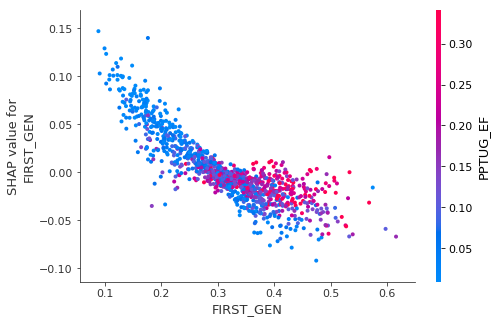

In [18]:
# Create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot('FIRST_GEN', shap_values[0], df_train, interaction_index='PPTUG_EF')

### DeepExplainer

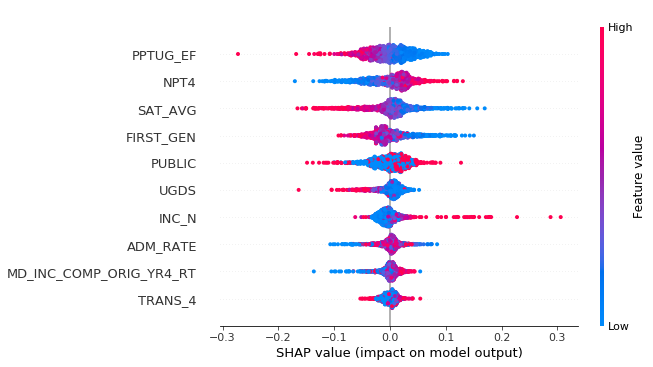

In [19]:
# DeepExplainer is optimized for neural network models
# It currently does not support eager execution or TF 2.0

explainer = shap.DeepExplainer(model, df_train_normed)
shap_values = explainer.shap_values(df_train_normed.values)
shap.summary_plot(shap_values[0], df_train)